In [1]:
import pandas as pd

df = pd.read_csv('synthetic_data_lung_cancer.csv')
df.head()

,SUBJECT_ID,DEFINITION_ID,TIME
0,1,drug_217,0.004807
1,1,condition_1922,0.008643
2,1,condition_785,0.027792
3,1,drug_49,0.032515
4,1,measurement_132,0.056765


In [2]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

data = df.sort_values(by=['SUBJECT_ID', 'TIME'])

last_entries = data.drop_duplicates('SUBJECT_ID', keep='last')
death_dict = {row['SUBJECT_ID']: (1 if row['DEFINITION_ID'] == 'death' else 0) for _, row in last_entries.iterrows()}

subject_data_list = []

for subject_id, group in data.groupby('SUBJECT_ID'):
    subject_data = {'SUBJECT_ID': subject_id}

    first_occurrences = group[group['DEFINITION_ID'] != 'death'].drop_duplicates('DEFINITION_ID')

    min_time = first_occurrences['TIME'].min()
    max_time = first_occurrences['TIME'].max()
    time_range = max_time - min_time

    for _, row in first_occurrences.iterrows():
        normalized_time = (row['TIME'] - min_time) / time_range if time_range > 0 else 0
        subject_data[row['DEFINITION_ID']] = normalized_time

    subject_data['death'] = death_dict[subject_id]

    subject_data_list.append(subject_data)

wide_data_first_occurrences = pd.DataFrame(subject_data_list)

wide_data_first_occurrences.fillna(0, inplace=True)

columns_to_normalize = wide_data_first_occurrences.columns.difference(['SUBJECT_ID', 'death'])
wide_data_first_occurrences[columns_to_normalize] = wide_data_first_occurrences[columns_to_normalize].apply(
    lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)

wide_data_first_occurrences.fillna(0, inplace=True)

In [3]:
wide_data_first_occurrences.head()

,SUBJECT_ID,drug_217,condition_1922,condition_785,drug_49,measurement_132,condition_1561,observation_182,condition_2391,condition_175,...,condition_429,condition_145,condition_2070,condition_755,condition_763,condition_1484,condition_976,condition_842,condition_1204,condition_807
0,1,0.0,0.000778,0.004665,0.005623,0.010544,0.010651,0.010820,0.012317,0.032821,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.800448,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,6,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


ROC AUC Score: 0.778505305938135


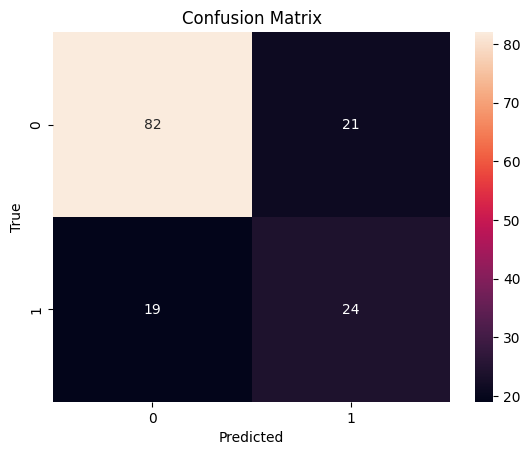

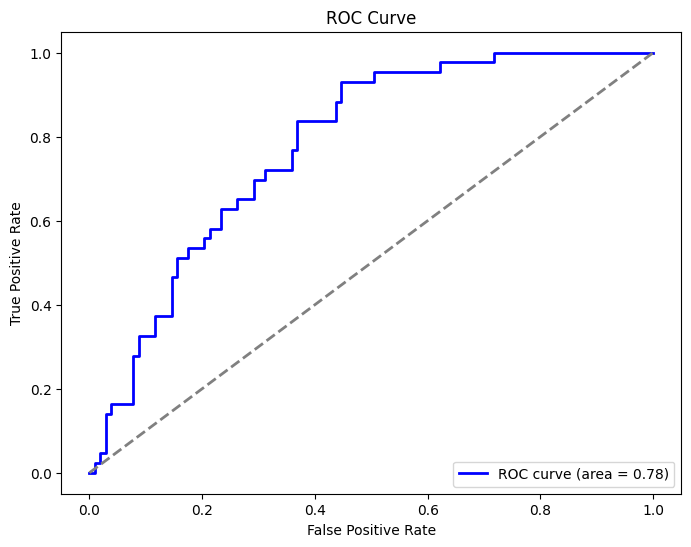

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
import seaborn as sns
from imblearn.over_sampling import SMOTE

features = wide_data_first_occurrences.drop(columns=['death'], axis=1)
labels = wide_data_first_occurrences['death']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

model = RandomForestClassifier(criterion= 'entropy', max_depth= 30, n_estimators= 1000)
model.fit(X_train_smote, y_train_smote)

y_pred = model.predict(X_test)

y_probs = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_probs)
print(f"ROC AUC Score: {roc_auc}")

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()